# XGBoost trainer

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api's.

## steps
1. generate an xgboost model configuration by selecting one of 5 available types
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset)
3. split the data into train, validation, and test sets.  

> _PLEASE NOTE_:  there are many approaches to cross validation (cv) and as many ways to implement cv in scikit learn.  In this third stage, an alternative, two-way train and test split can be created.  The training set would then, for example, serve as input to a cross validation splitter.  The latter creates multiple training and validation subsets, called folds. These folds are then input, either in sequence or in parallel into the fit algorithm.

4. train the model
5. dump the model
6. generate predictions and probabilities
7. (calibrate probabilities if needed, wip)
8. calculate evaluation statistics and plots

All these steps have been separated here into independent functions since many can be reused for other model types. Some of the following functions will be transferred in the `mlrun.mlutils` module. Additionally, each function contains its own imports in order to isolate and identify dependencies.

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
from  mlrun.mlutils import (get_sample,
                            get_splits,
                            gen_sklearn_model,
                            create_class, 
                            eval_class_model)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from cloudpickle import dumps

## generate an xgb model

generate a model config using the xgboost's sklearn api

In [5]:
def gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlrun.mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    from mlrun.mlutils import get_class_fit, gen_sklearn_model

    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

## train

In [6]:
def train_model(
    context: MLClientCtx,
    model_type: str,
    dataset: DataItem,
    label_column: str = "labels",
    sample: int = -1,
    test_size: float = 0.05,
    valid_size: float = 0.75,
    random_state: int = 1,
    model_filename: str = "xgb-model",
    models_dest: str = "",
    plots_dest: str = "",
    score_method: str = "micro",
    file_ext: str = "parquet",
    model_pkg_file: str = "",    
) -> None:
    """train an xgboost model.

    :param context:           the function context
    :param model_type:        the model type to train, 'classifier', 'regressor'...
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param model_filename:    model file filename,  points to a directory
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param file_ext:          format for test_set_key hold out data
    """
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain,ytrain), (xvalid,yvalid), \
    (xtest,ytest), (xcal, ycal) = get_splits(
        raw, labels, 4,
        test_size, 
        valid_size, 
        ["labels"],
        random_state)
        
    # get model config
    model_config = gen_xgb_model(model_type, context.parameters.items())
    model_short_name = model_config["META"]["class"].split('.')[-1]
   
    # create model instance
    XGBBoostClass = create_class(model_config["META"]["class"])
    model = XGBBoostClass(**model_config["CLASS"])

    # update the model config with training data and callbacks
    model_config["FIT"].update({"X": xtrain,"y": ytrain.values})
    
    # run the fit
    model.fit(**model_config["FIT"])

    # evaluate model
    eval_metrics = eval_class_model(xvalid, yvalid, model)
    model_plots = eval_metrics.pop("plots")
    # just do this inside log_model?
    for plot in model_plots:
        context.log_artifact(plot, local_path=f'{plots_dest}/{plot.key}.html')
        
    # serialize the model
    model_bin = dumps(model.get_booster())
    context.log_model(model_short_name, body=model_bin, 
                      model_dir="models", 
                      model_file='model.pkl',
                      metrics=eval_metrics)
    # cant see them from log_model so try this:
    context.log_results(eval_metrics)

In [7]:
# nuclio: end-code

### mlconfig

In [8]:
from mlrun import mlconf
import os
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [9]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_trainer")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["models", "classifier"]
fn.metadata.labels = {"author": "yjb"}

fn.save()
fn.export("function.yaml")

[mlrun] 2020-05-03 14:54:20,922 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 14:54:20,954 function spec saved to path: function.yaml


### test function

In [10]:
if "V3IO_HOME" in list(os.environ):
    # mlrun on the iguazio platform
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # mlrun is setup using the instructions at 
    # https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc("nfsvol", "nfsvol", "/home/joyan/data"))

In [11]:
gpus = False

task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "model_type"         : "classifier",
        "num_class"          : 3,
        "CLASS_tree_method"  : "gpu_hist" if gpus else "hist",
        "CLASS_objective"    : "multi:softmax",
        'CLASS_n_estimators' : 100,
        "CLASS_max_depth"    : 6,
        "CLASS_booster"      : "gbtree",  
        "CLASS_random_state" : 1,
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.10,
        "valid_size"         : 0.75,
        "score_method"       : "weighted",
        "models_dest"        : "xgb_trainer/models",
        "plots_dest"         : "xgb_trainer/plots",
    }}

### run locally

[mlrun] 2020-05-03 14:54:23,728 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-03 14:54:23,728 starting run tasks xgb cpu trainer uid=7f4b59f5ccf248968f070d8fcca7cb3d  -> http://mlrun-api:8080
[mlrun] 2020-05-03 14:54:23,755 warning!, server (0.4.6) and client (0.4.7) ver dont match


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[mlrun] 2020-05-03 14:54:25,226 log artifact confusion-matrix at /home/jovyan/data/xgb_trainer/plots/confusion-matrix.html, size: 13435, db: Y
[mlrun] 2020-05-03 14:54:25,281 log artifact precision-recall-multiclass at /home/jovyan/data/xgb_trainer/plots/precision-recall-multiclass.html, size: 37386, db: Y
[mlrun] 2020-05-03 14:54:25,327 log artifact roc-multiclass at /home/jovyan/data/xgb_trainer/plots/roc-multiclass.html, size: 32513, db: Y
[mlrun] 2020-05-03 14:54:25,340 log artifact XGBClassifier at /home/jovyan/data/models/, size: 66274, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...a7cb3d,0,May 03 14:54:23,completed,tasks xgb cpu trainer,kind=handlerowner=jovyanhost=jupyter-notebook-7c79d94f7d-c2lr9,dataset,model_type=classifiernum_class=3CLASS_tree_method=histCLASS_objective=multi:softmaxCLASS_n_estimators=100CLASS_max_depth=6CLASS_booster=gbtreeCLASS_random_state=1sample=-1label_column=labelstest_size=0.1valid_size=0.75score_method=weightedmodels_dest=xgb_trainer/modelsplots_dest=xgb_trainer/plots,accuracy=0.9705882352941176test-error-rate=22.38235294117647precision-micro-avg-classes=0.998294611962432auc-macro=1.0auc-weighted=1.0f1-score=0.9731615673644659recall_score=0.9722222222222222,confusion-matrixprecision-recall-multiclassroc-multiclassXGBClassifier


to track results use .show() or .logs() or in CLI: 
!mlrun get run 7f4b59f5ccf248968f070d8fcca7cb3d --project default , !mlrun logs 7f4b59f5ccf248968f070d8fcca7cb3d --project default
[mlrun] 2020-05-03 14:54:25,369 run executed, status=completed


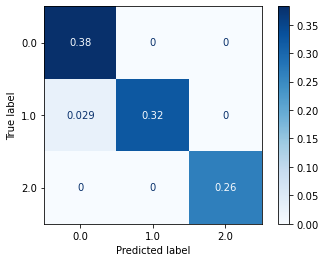

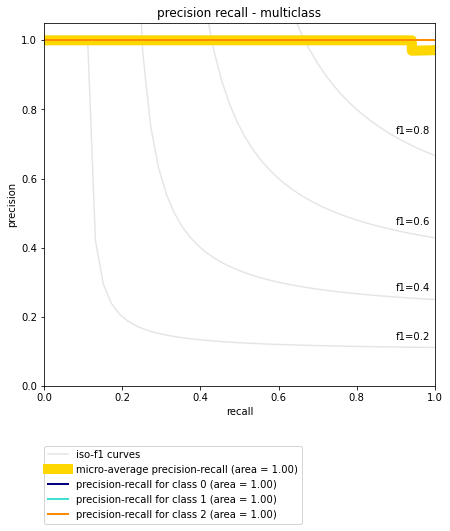

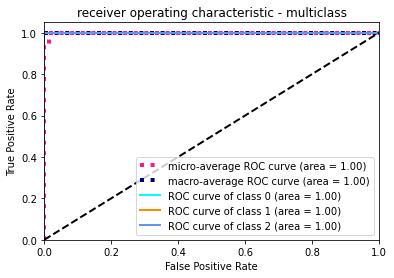

In [12]:
from mlrun import run_local, NewTask

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : os.path.join(mlconf.artifact_path, "iris.parquet")})

### run remotely

In [13]:
run = fn.run(
    NewTask(**task_params),
    inputs={"dataset"  : os.path.join(mlconf.artifact_path, "breast_cancer.parquet")})

[mlrun] 2020-05-03 14:54:47,725 starting run tasks xgb cpu trainer uid=cad9c6daf56e4f70a1f443c0ee38175b  -> http://mlrun-api:8080
[mlrun] 2020-05-03 14:54:48,132 Job is running in the background, pod: tasks-xgb-cpu-trainer-kmwpq
Traceback (most recent call last):
  File "/opt/conda/bin/mlrun", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 956, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 555, in invoke
    return callback(*args, **kwargs)
  File "/opt/conda/lib/python3.7/sit

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...38175b,0,May 03 14:54:51,error,tasks xgb cpu trainer,kind=jobowner=jovyan,dataset,CLASS_booster=gbtreeCLASS_max_depth=6CLASS_n_estimators=100CLASS_objective=multi:softmaxCLASS_random_state=1CLASS_tree_method=histlabel_column=labelsmodel_type=classifiermodels_dest=xgb_trainer/modelsnum_class=3plots_dest=xgb_trainer/plotssample=-1score_method=weightedtest_size=0.1valid_size=0.75,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run cad9c6daf56e4f70a1f443c0ee38175b  , !mlrun logs cad9c6daf56e4f70a1f443c0ee38175b 
[mlrun] 2020-05-03 14:54:54,259 run executed, status=error
runtime error: error, check logs


RunError: error, check logs

## tests

In [14]:
# WIP


# def test_gen_xgb_model():
#     import xgboost
#     c, j = _gen_xgb_model("rf_classifier", {})
#     assert isinstance(c, xgboost.XGBRFClassifier)
# test_gen_xgb_model()

# breast_cancer = get_dataitem(mlconf.artifact_path+"/breast_cancer.parquet")
# classifier-data = get_dataitem(mlconf.artifact_path+"/classifier-data.csv")
# iris = get_dataitem(mlconf.artifact_path+"/iris.parquet")

# def test_get_sample():
#     from mlrun import mlconf
#     r, l, h = _get_sample(breast_cancer, -1, "labels")
#     assert r.shape[0]==l.shape[0]
# test_get_sample()

# def test_get_splits():
#     from mlrun import mlconf
#     r, l, h = _get_sample(classifier-data, -1, "labels")
#     (xtr, ytr), (xva, yva), (xte, yte), (xcal, ycal) = _get_splits(r, l, 4)

#     assert xtr.shape[0]+xva.shape[0]+xte.shape[0]+xcal.shape[0] == r.shape[0]
# test_get_splits()

# #def test_save_test_set():
# r, l, h = _get_sample(iris, -1, "labels")
# A = _get_splits(r,l,3)
# from mlrun import get_or_create_ctx
# _save_test_set(get_or_create_ctx("test"), A[2][1], A[2][1], h, debug=True)
# import pandas as pd
#     # pd.read_parquet()
#     # assert
# #test_save_test_set()